In [1]:
# 目前估计能做 4 列 [100,100,100,10]，再多内存就存不下 node了
# 一般来说，增加query size 能覆盖更多的网格点，但是我们现在在对多个列同时采样的时候是选取随机一行中的值，所以graph.y有可能覆盖不到所有的网格点
# 目前没有用到 batch
# 对于 test-2.csv，使用 100 query size，从学习效果看，似乎是够的（除了右下角的点误差有点大）

usage: ipykernel_launcher.py [-h] [--model MODEL] [--dataset DATASET]
                             [--query-size QUERY_SIZE]
                             [--min-conditions MIN_CONDITIONS]
                             [--max-conditions MAX_CONDITIONS]
                             [--unique-train UNIQUE_TRAIN]
                             [--boundary BOUNDARY] [--channels CHANNELS]
                             [--epochs EPOCHS] [--bs BS] [--loss LOSS]
                             [--opt OPT] [--lr LR]
ipykernel_launcher.py: error: unrecognized arguments: --f=/Users/chun/Library/Jupyter/runtime/kernel-v3a576e18662fec9a3357b86d49314ce04e9e31e1d.json


PyTorch is using device: cpu

Begin Loading Data ...
test-2.csv,    shape: (100, 2)
Done.

Begin Generating Queries Set ...


100%|██████████| 100/100 [00:00<00:00, 18125.77it/s]


Done.

Begin Intervalization ...
column_interval_number=[55, 43]
Done.

Begin Building Graph and Model ...


100%|██████████| 1/1 [00:00<00:00, 51.76it/s]

Nodes: 2365
Edges: 4632
Done.

Begin Model Training ...
Epoch 1, Loss: 1220339.875


Epoch 300, Loss: 0.04424600303173065
Epoch 600, Loss: 0.044170085340738297
Epoch 900, Loss: 0.04406605660915375
Epoch 1200, Loss: 0.04393498972058296
Epoch 1500, Loss: 0.04377874359488487
Epoch 1800, Loss: 0.04360191151499748
Epoch 2100, Loss: 0.04340390861034393
Epoch 2400, Loss: 0.043189045041799545
Epoch 2700, Loss: 0.04296046495437622
Epoch 3000, Loss: 0.042723845690488815
Done.

Begin Model Prediction ...


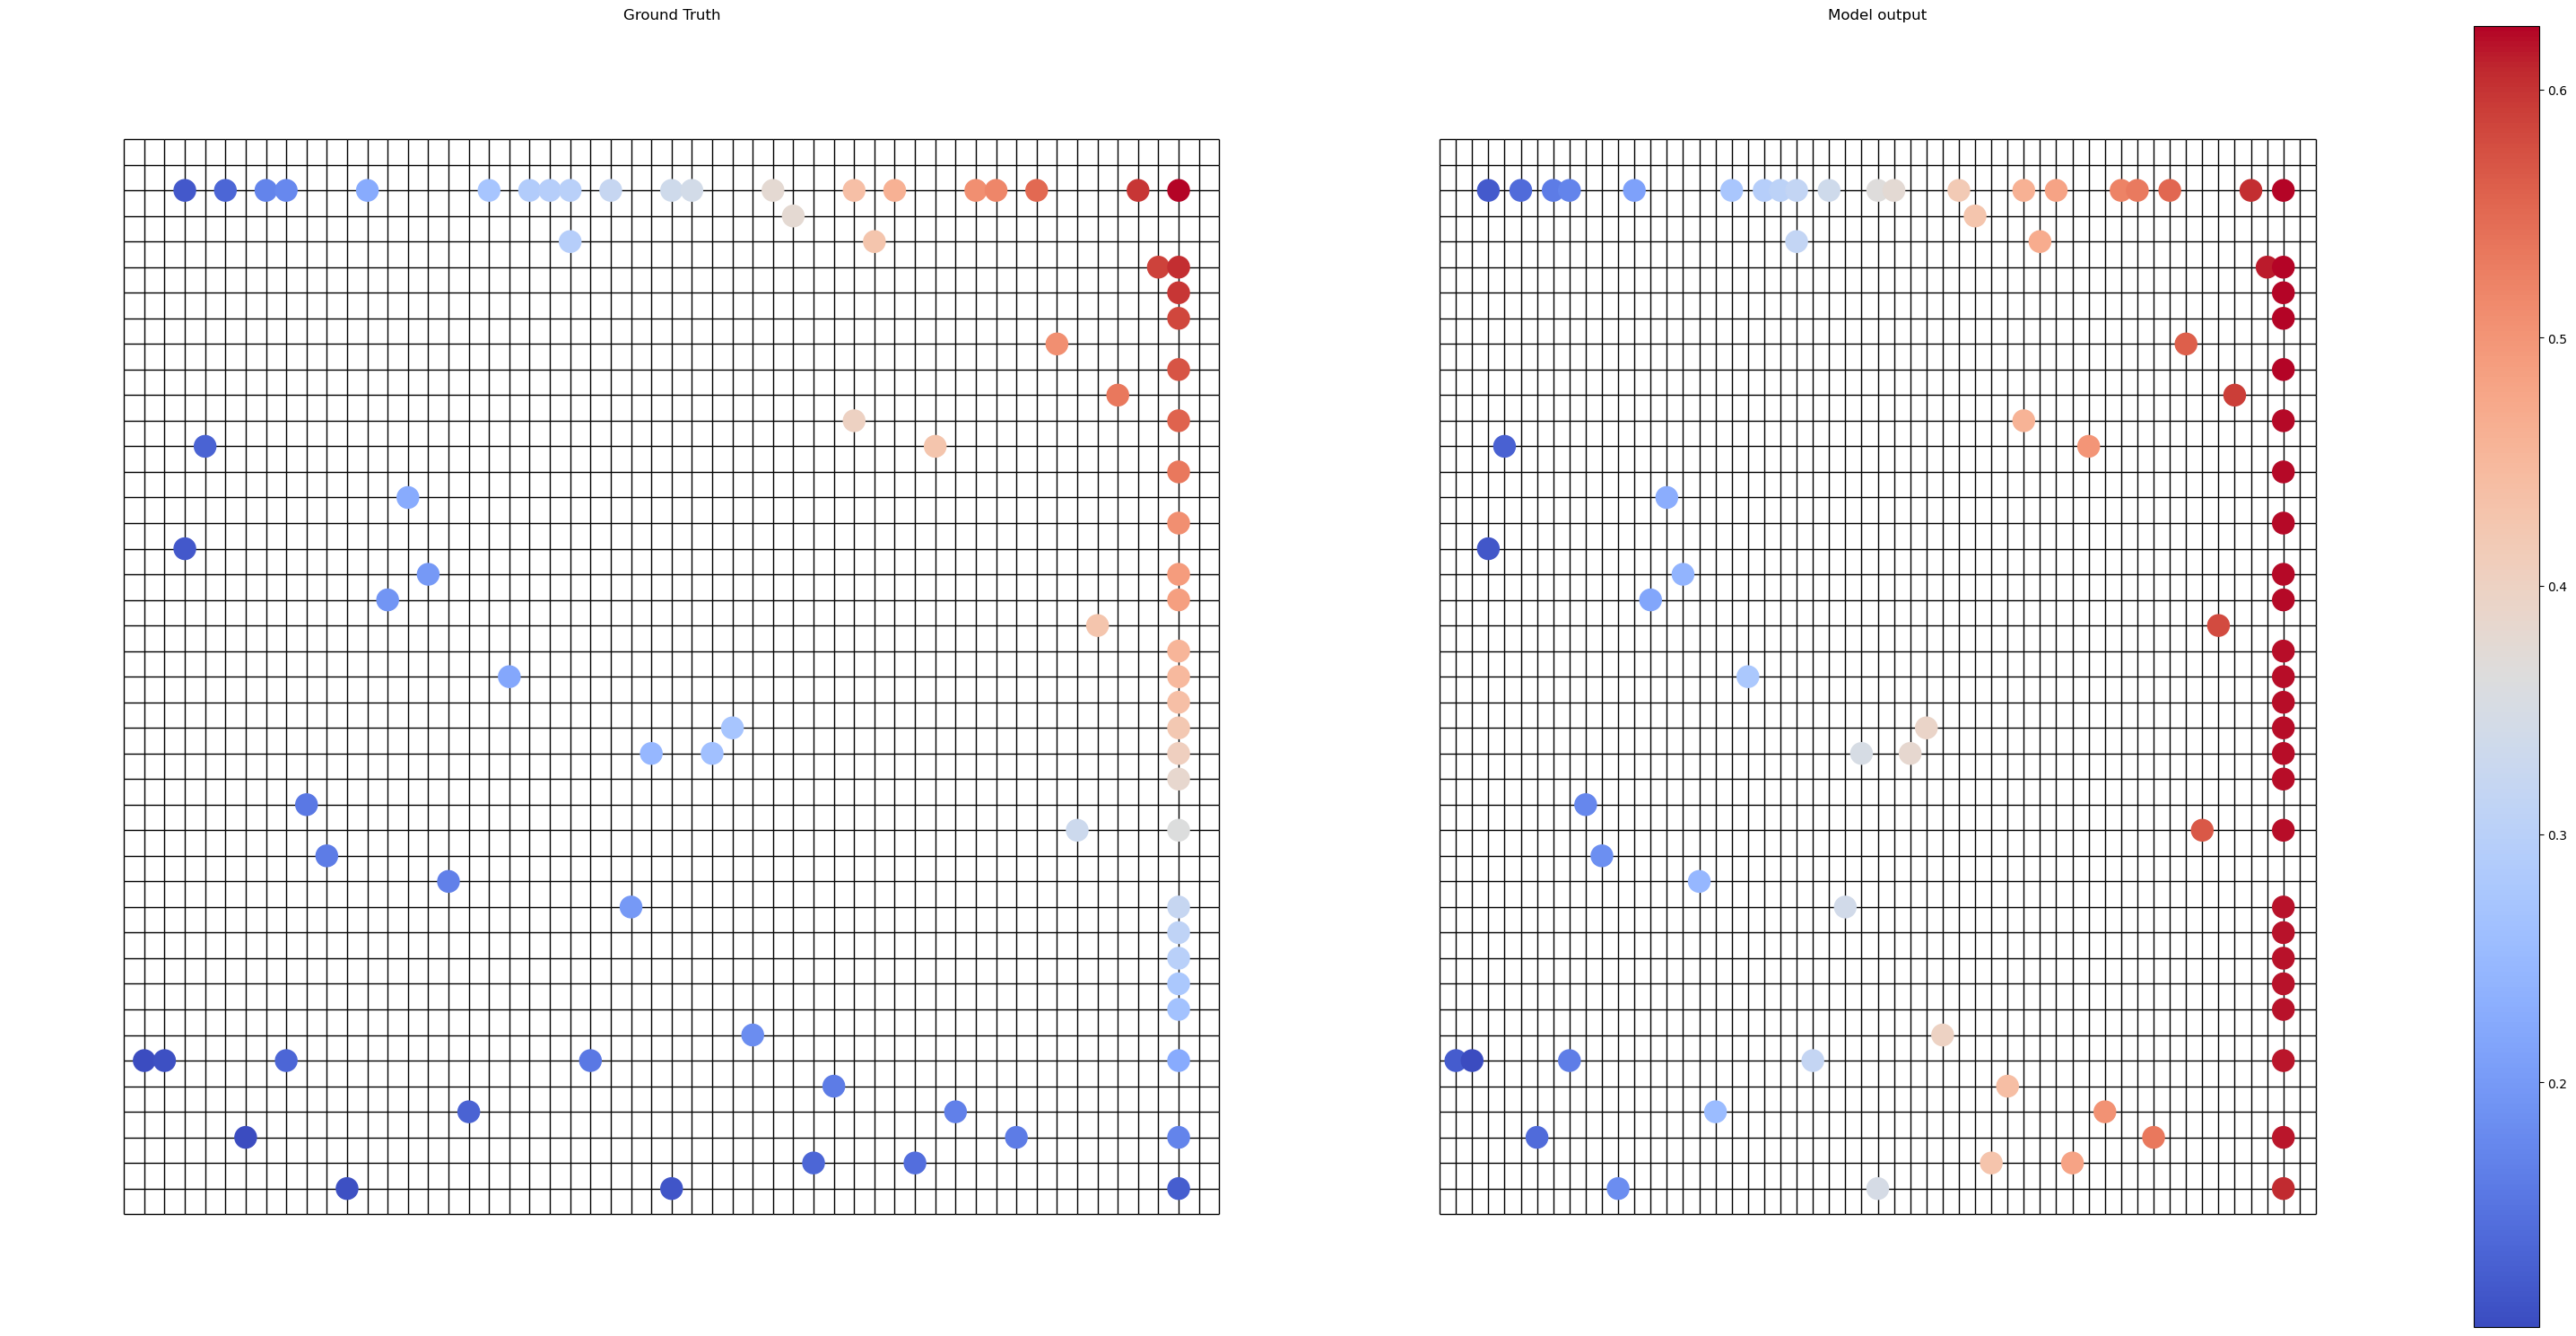

In [2]:
import argparse

from dataset import *
from models import *
from preprocessing import *
from utils import *

parser = argparse.ArgumentParser()
parser.add_argument("--model", type=str, default="1-input", help="model type")
parser.add_argument("--dataset", type=str, default="test-2", help="Dataset.")
parser.add_argument("--query-size", type=int, default=100, help="query size")
parser.add_argument("--min-conditions", type=int, default=1, help="min num of query conditions")
parser.add_argument("--max-conditions", type=int, default=2, help="max num of query conditions")
parser.add_argument(
    "--unique-train", type=bool, default=True, help="whether make train set unique."
)
parser.add_argument(
    "--boundary", type=bool, default=False, help="whether add boundary point to train set."
)
parser.add_argument("--channels", type=list, default=[1, 16, 1], help="channels.")
parser.add_argument("--epochs", type=int, default=3000, help="Number of train epochs.")
parser.add_argument("--bs", type=int, default=1000, help="Batch size.")
parser.add_argument("--loss", type=str, default="MSE", help="Loss.")
parser.add_argument("--opt", type=str, default="adam", help="Optimizer.")
parser.add_argument("--lr", type=float, default=1e-2, help="learning rate")


try:
    args = parser.parse_args()
except:
    # args = parser.parse_args([])
    args, unknown = parser.parse_known_args()


FilePath = (
    f"{args.dataset}_{args.query_size}_{args.min_conditions}_{args.max_conditions}_{args.model}"
)


def make_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)


resultsPath = f"results/{FilePath}"
modelPath = f"models/{FilePath}"
make_directory(resultsPath)
make_directory(modelPath)


print("\nBegin Loading Data ...")
table, original_table_columns, sorted_table_columns, max_decimal_places = load_and_process_dataset(
    args.dataset, resultsPath
)
table_size = table.shape
print(f"{args.dataset}.csv,    shape: {table_size}")
print("Done.\n")


print("Begin Generating Queries Set ...")
rng = np.random.RandomState(42)
query_set = [generate_random_query(table, args, rng) for _ in tqdm(range(args.query_size))]
print("Done.\n")


print("Begin Intervalization ...")
unique_intervals = column_intervalization(query_set, table_size)
column_interval_number = count_unique_vals_num(unique_intervals)
print(f"{column_interval_number=}")
print("Done.\n")

print("Begin Building Graph and Model ...")
graph = setup_graph(args, query_set, unique_intervals, column_interval_number, table_size)
# Visualize_initial_Graph_2D(graph, column_interval_number)
model = BaseModel(args, modelPath, graph, device)
graph = graph.to(device)
print("Done.\n")


print("Begin Model Training ...")
model.fit()
print("Done.\n")

print("Begin Model Prediction ...")
# model.load()
out = model.predict(graph).squeeze(dim=-1).detach().cpu()
# print(f"{out=}\n")
# print(f"{out[graph.train_mask]=}\n")
# print(f"{graph.y[graph.train_mask]=}\n")
Visualize_compare_Graph_2D(
    graph, column_interval_number, out, figsize=(30, 15), to_undirected=True, with_labels=False
)

# Table_Generated = m.generate_table_by_row(values, batch_size=10000)
# Q_error = calculate_Q_error(Table_Generated, query_set)
# print_Q_error(Q_error, args, resultsPath)
# print(f"\n Original table shape : {table_size}")
# print(f"Generated table shape : {Table_Generated.shape}")

# recovered_Table_Generated = recover_table_as_original(
#     Table_Generated, original_table_columns, sorted_table_columns, max_decimal_places
# )
# recovered_Table_Generated.to_csv(f"{resultsPath}/generated_table.csv", index=False, header=False)